<Axes: >

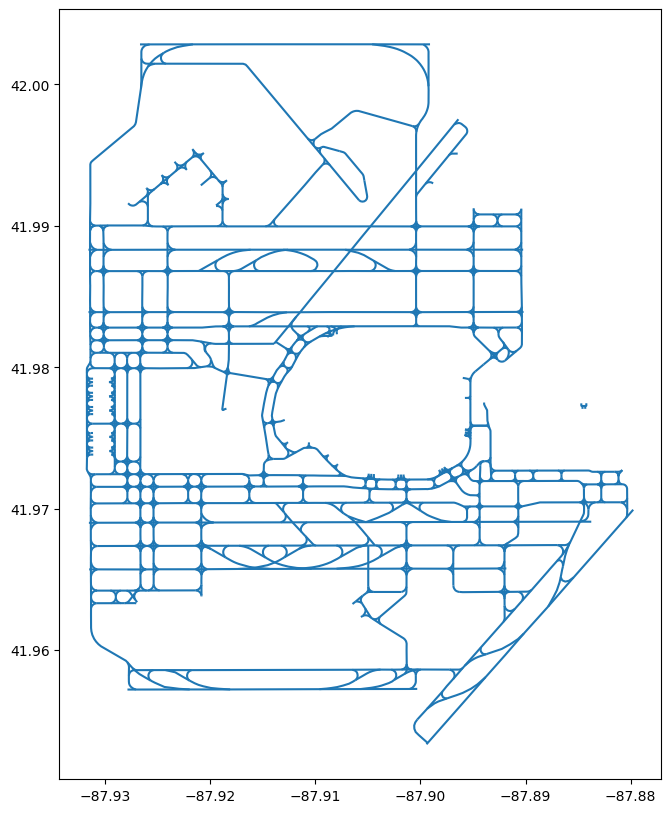

In [5]:
import osmnx as ox

# defines tags and place
tags = {"aeroway": ["taxiway", "runway"]}
place = "O'Hare International Airport, Chicago, Illinois, USA"

# gets geospatial data
gdf = ox.features_from_place(place, tags)

gdf.plot(figsize=(10, 10))

In [6]:
import osmnx as ox
import matplotlib.pyplot as plt
from shapely.geometry import LineString

def plot_runway_checkpoints(place_name):
    # defines tags and get geospatial data for the place
    tags = {"aeroway": ["taxiway", "runway"]}
    gdf = ox.features_from_place(place_name, tags)

    # filters for runway only
    runways = gdf[gdf["aeroway"] == "runway"]

    # creates a figure and axis for plotting
    fig, ax = plt.subplots(figsize=(10, 10))
    gdf.plot(ax=ax, color='lightgray')

    # loops through each runway and extract endpoints
    # for each runway, it checks if it is a LineString (most are),
    # it extracts the first and last coordinate pair from the line and plots them
    for idx, row in runways.iterrows():
        geom = row.geometry
        if isinstance(geom, LineString):
            start = geom.coords[0]
            end = geom.coords[-1]

            # Plot start and end
            ax.plot(start[0], start[1], 'ro')  # red = start
            ax.plot(end[0], end[1], 'go')      # green = end

            # Optional labels
            ax.text(start[0], start[1], 'Start', fontsize=8, color='red')
            ax.text(end[0], end[1], 'End', fontsize=8, color='green')

    plt.title(f"Runways with Auto-Detected Start/End Checkpoints\n{place_name}")
    plt.show()

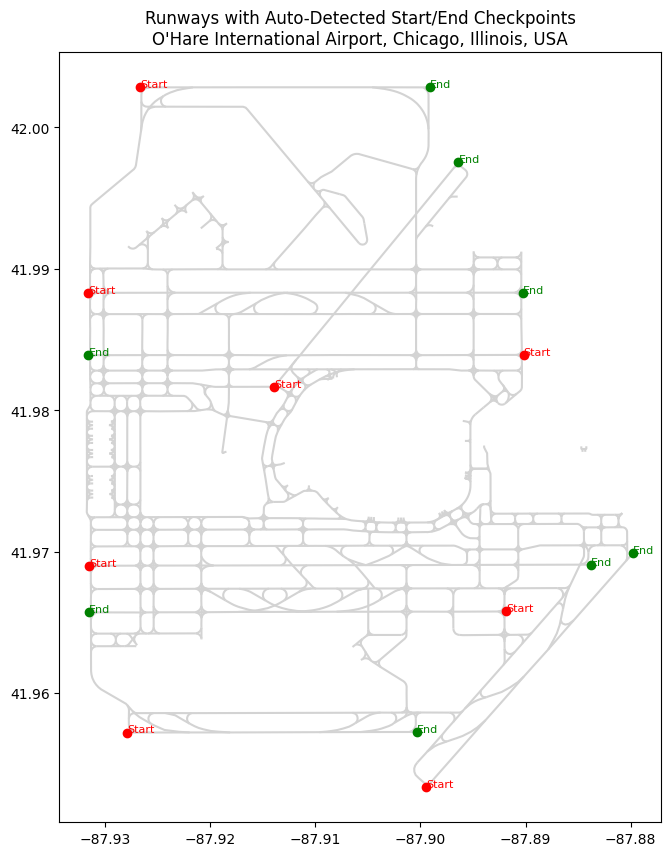

In [7]:
plot_runway_checkpoints("O'Hare International Airport, Chicago, Illinois, USA")

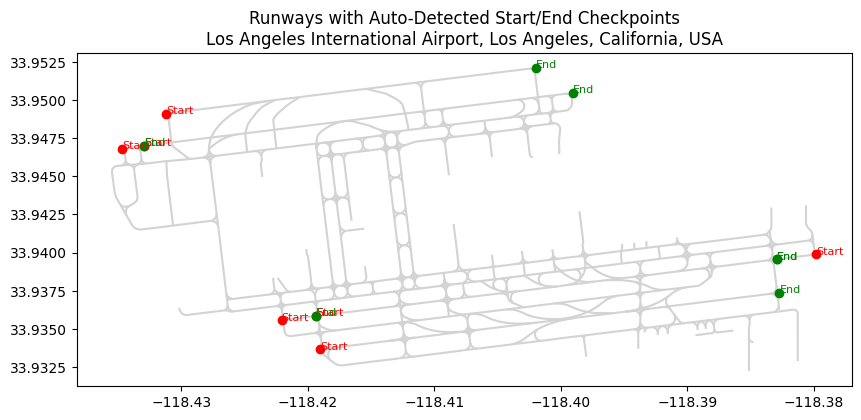

In [8]:
plot_runway_checkpoints("Los Angeles International Airport, Los Angeles, California, USA")

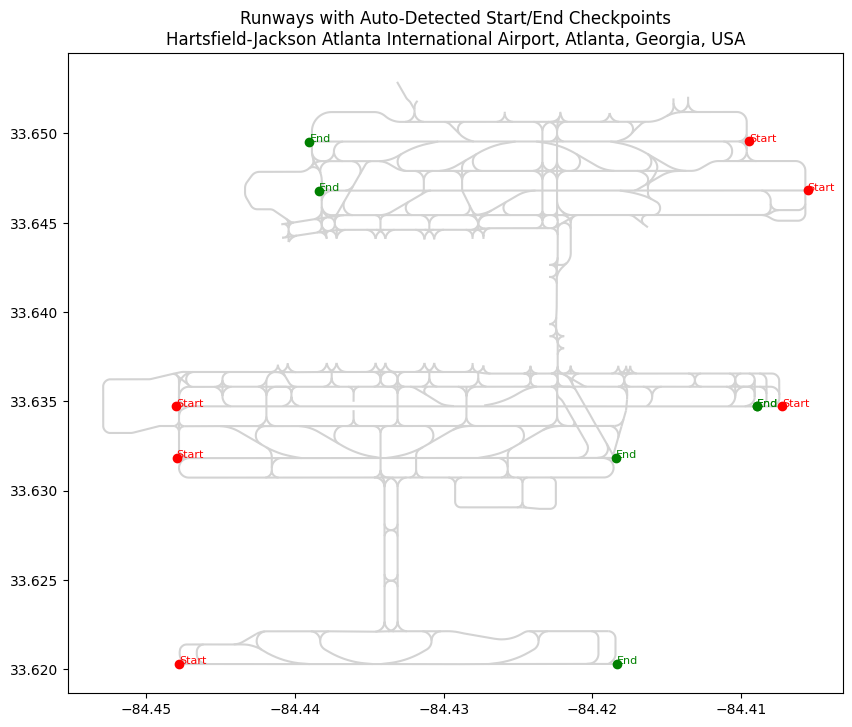

In [9]:
plot_runway_checkpoints("Hartsfield-Jackson Atlanta International Airport, Atlanta, Georgia, USA")

In [10]:
import osmnx as ox
import networkx as nx
from shapely.geometry import LineString, MultiLineString

def extract_taxiway_graph(place_name, export_graphml=False):
    # extracts a taxiway graph from OpenStreetMap data using custom aeroway tags
    # the nodes represent connection points; edges represent taxiway segments
    tags = {"aeroway": "taxiway"}
    gdf = ox.features_from_place(place_name, tags)

    G = nx.Graph()

    for idx, row in gdf.iterrows():
        geom = row.geometry

        if isinstance(geom, LineString):
            coords = list(geom.coords)
            for i in range(len(coords) - 1):
                p1 = coords[i]
                p2 = coords[i + 1]
                G.add_edge(p1, p2, geometry=LineString([p1, p2]))
        
        elif isinstance(geom, MultiLineString):
            for line in geom.geoms:
                coords = list(line.coords)
                for i in range(len(coords) - 1):
                    p1 = coords[i]
                    p2 = coords[i + 1]
                    G.add_edge(p1, p2, geometry=LineString([p1, p2]))

    print(f"Taxiway graph built with {G.number_of_nodes()} nodes and {G.number_of_edges()} edges.")

    return G

In [11]:
def plot_taxiway_graph(G):
    fig, ax = plt.subplots(figsize=(10, 10))
    for u, v, data in G.edges(data=True):
        line = data['geometry']
        x, y = line.xy
        ax.plot(x, y, color='blue', linewidth=1)

    for node in G.nodes:
        ax.plot(node[0], node[1], 'ko', markersize=1)  # plot nodes

    plt.title("Taxiway Network with Nodes")
    plt.show()

[✓] Taxiway graph built with 6209 nodes and 6857 edges.


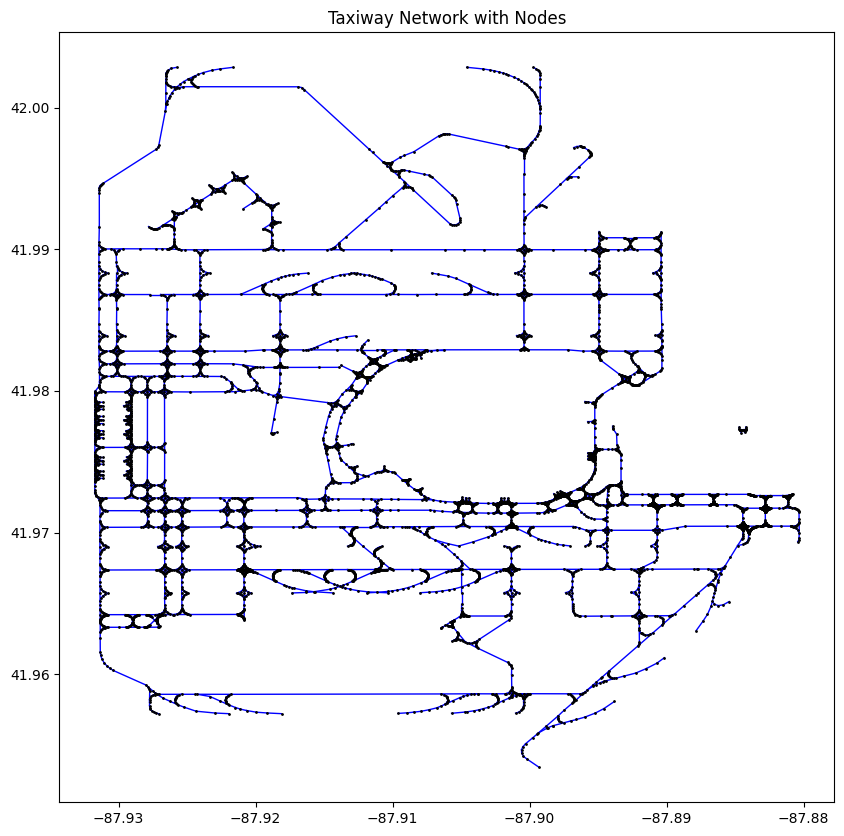

In [12]:
G = extract_taxiway_graph("O'Hare International Airport, Chicago, Illinois, USA")
plot_taxiway_graph(G)

In [19]:
import random
import networkx as nx
from shapely.geometry import LineString

def simulate_obstacle_reroute(G, block_random=True):
    nodes = list(G.nodes)
    source = random.choice(nodes)
    target = random.choice(nodes)

    try:
        original_path = nx.shortest_path(G, source=source, target=target)
    except nx.NetworkXNoPath:
        print("❌ No path found between nodes.")
        return

    if block_random:
        block_node = random.choice(original_path[1:-1])
    else:
        block_node = original_path[len(original_path) // 2]  # block the middle

    print(f"🚧 Blocking node: {block_node}")
    G_mod = G.copy()
    G_mod.remove_node(block_node)

    try:
        rerouted_path = nx.shortest_path(G_mod, source=source, target=target)
    except nx.NetworkXNoPath:
        print("❌ No rerouted path found after blocking.")
        return

    fig, ax = plt.subplots(figsize=(10, 10))

    # uses G_mod (with blocked node) to draw the updated taxiway graph
    for u, v, data in G_mod.edges(data=True):
        line = data['geometry']
        if line:  # Make sure geometry exists
            x, y = line.xy
            ax.plot(x, y, color='lightgray', linewidth=0.5)


    # plots original path (blue solid)
    for i in range(len(original_path) - 1):
        x_vals = [original_path[i][0], original_path[i + 1][0]]
        y_vals = [original_path[i][1], original_path[i + 1][1]]
        ax.plot(x_vals, y_vals, 'b-', linewidth=2, label='Original Path' if i == 0 else "")

    # plots rerouted path (red dashed)
    for i in range(len(rerouted_path) - 1):
        x_vals = [rerouted_path[i][0], rerouted_path[i + 1][0]]
        y_vals = [rerouted_path[i][1], rerouted_path[i + 1][1]]
        ax.plot(x_vals, y_vals, 'r--', linewidth=2, label='Rerouted Path' if i == 0 else "")


    # marks source and target
    ax.plot(source[0], source[1], 'go', markersize=6, label='Source')
    ax.plot(target[0], target[1], 'mo', markersize=6, label='Target')
    ax.plot(block_node[0], block_node[1], 'kx', markersize=8, label='Blocked Node')
    

    plt.title("Taxiway Obstacle Avoidance Routing")
    ax.legend()
    plt.show()

[✓] Taxiway graph built with 6209 nodes and 6857 edges.
🚧 Blocking node: (-87.9313473, 41.966237)


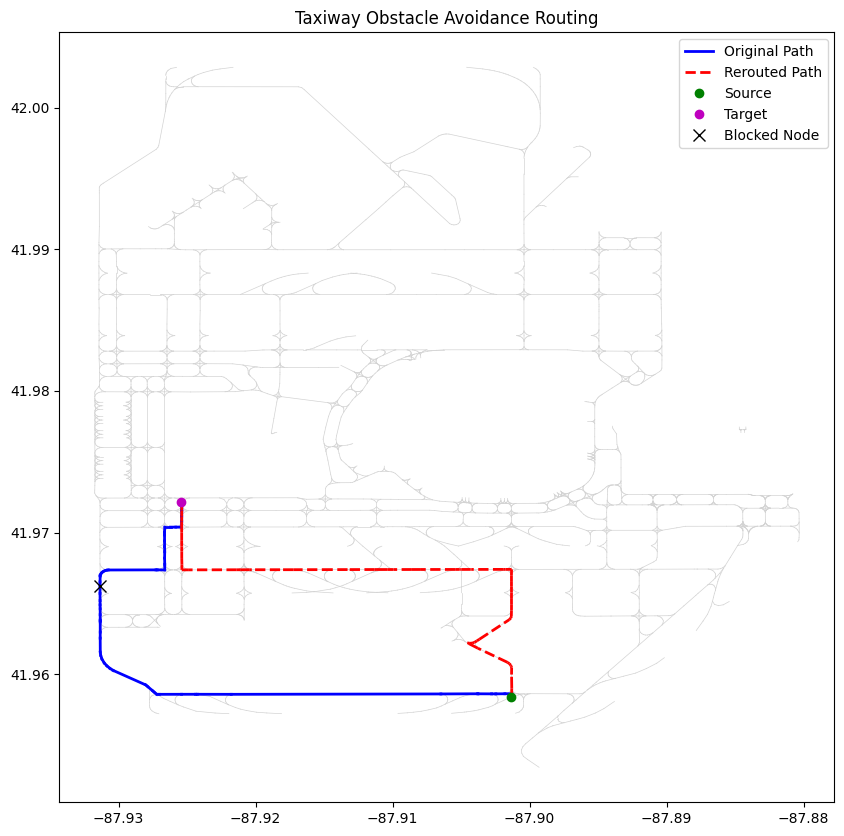

In [20]:
G = extract_taxiway_graph("O'Hare International Airport, Chicago, Illinois, USA")
simulate_obstacle_reroute(G)